<a href="https://colab.research.google.com/github/DhruvDarda/Super-Resolution/blob/main/SRGAN_intern_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Single Image Super Resolution using SRGAN

Source : https://ieeexplore.ieee.org/document/8099502


In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

from PIL import Image
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter

'''import plotly
import plotly.express as px
import plotly.graph_objects as go
from scipy import signal
from scipy import ndimage'''
import matplotlib.pyplot as plt


random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/happy_images/DIV2K_valid_HR/

#!unzip '/content/drive/MyDrive/DIV2K/DIV2K_train_HR.zip' -d '/content/drive/MyDrive/happy_images/DIV2K_valid_HR/'

writer = SummaryWriter('/content/drive/MyDrive/happy_imagesruns/metrics')
slpath = '/content/drive/MyDrive/happy_images/'

Mounted at /content/drive
/content/drive/MyDrive/happy_images/DIV2K_valid_HR


In [ ]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose(
            [   
                #transforms.RandomHorizontalFlip(0.7),
                #transforms.Pad(2),
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                #transforms.RandomHorizontalFlip(0.7),
                #transforms.Pad(2),
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.files = files #sorted(glob.glob(root + "/*.*"))
        #print(self.hr_transform(Image.open(self.files[3])).shape)
    
    def add_margin(self, pil_img):
        width, height = pil_img.size
        left = (256-width)//2
        top = (256-height)//2
        result = Image.new(pil_img.mode, (256, 256), (0,0,0))
        result.paste(pil_img, (left, top))
        return result

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert('RGB')
        o_height, o_width = img.size
        if o_height < 256 or o_width < 256:
            img = self.add_margin(img)
        #img = cv2.copyMakeBorder(img, (256-o_height)//2, (256-o_height)//2, (256-o_width)//2, (256-o_width)//2, cv2.BORDER_CONSTANT)
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
            
        return {"lr": img_lr, "hr": img_hr}
    
    def __len__(self):
        return len(self.files)


In [ ]:
'''
path = %pwd
import glob
import shutil
import os
src_dir = path + "/DIV2K_train_HR"
dst_dir = path
for jpgfile in os.listdir(src_dir): #glob.iglob(os.path.join(src_dir, "*.jpg")):
  print(jpgfile)
  shutil.copyfile(src_dir + '/' + jpgfile, dst_dir + '/' + jpgfile)
'''

'\npath = %pwd\nimport glob\nimport shutil\nimport os\nsrc_dir = path + "/DIV2K_train_HR"\ndst_dir = path\nfor jpgfile in os.listdir(src_dir): #glob.iglob(os.path.join(src_dir, "*.jpg")):\n  print(jpgfile)\n  shutil.copyfile(src_dir + \'/\' + jpgfile, dst_dir + \'/\' + jpgfile)\n'

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        #layers.append(nn.Conv2d(out_filters, 1024, kernel_size=3, stride=1, padding=1))
        #layers.append(nn.LeakyReLU(0.2, inplace=True))
        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [ ]:
def to_np(x):
    return x.data.cpu().numpy()

In [ ]:
def plot_train_result(real_image, gen_image, recon_image, epoch=1, save=False,  show=True, fig_size=(15, 6)):
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [to_np(real_image), to_np(gen_image), to_np(recon_image),
            to_np(real_image), to_np(gen_image), to_np(recon_image)]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = 'Result_epoch_{:d}'.format(epoch) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
def load(PATH, model, optimizer):  
  checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  epoch_loss = checkpoint['loss']
  return epoch, model, optimizer, epoch_loss

In [ ]:
load_pretrained_models = True
n_epochs = 191       #div2k = 174  #mixed = 108
dataset_path = %pwd
batch_size = 1
lr = 0.01
b1 = 0.5
b2 = 0.999
decay_epoch = 85
n_cpu = 2
hr_height = 256
hr_width = 256
channels = 3

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

In [ ]:
train_paths = os.listdir(dataset_path)

train_paths.remove('animal')
train_paths.remove('OutdoorSceneTest300')
train_paths.remove('images')
train_paths.remove('saved_models')
train_paths.remove('plant')
train_paths.remove('DIV2K_train_HR')

#train_paths = [os.path.join(dataset_path+'/DIV2K_train_HR/', i) for i in train_paths]
'''
for i in train_paths:
    if os.path.getsize(os.path.join(dataset_path, i)) > 6*(1024**2):
      train_paths.remove(i)
'''
#test_paths = glob.glob(dataset_path + "val/*.*")
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
#test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=1, shuffle=False, num_workers=n_cpu)

In [ ]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()


#generator.load_state_dict(torch.load("../input/mathsfinalcode/saved_models/generator.pth"))
#discriminator.load_state_dict(torch.load("../input/mathsfinalcode/saved_models/discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.RAdam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.RAdam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
'''
def psnr(lr_path, hr_path):
    lr = io.imread(lr_path).astype(np.float32) / 255
    hr = io.imread(hr_path).astype(np.float32) / 255

    m, n, c = lr.shape[0], hr.shape[1], hr.shape[2]
    mse = np.sum((lr - hr) ** 2) / (m * n * c)

    return 10 * math.log10(1 / mse)
'''
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    #print(type(ssim_map))
    return ssim_map.mean()

    
def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssim_s = []
            for i in range(3):
                #print(ssim(img1, img2))
                ssim_s.append(ssim(img1, img2))
            return np.array(ssim_s).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

Training Epoch 188 / 191:   0%|          | 0/3303 [00:00<?, ?it/s]

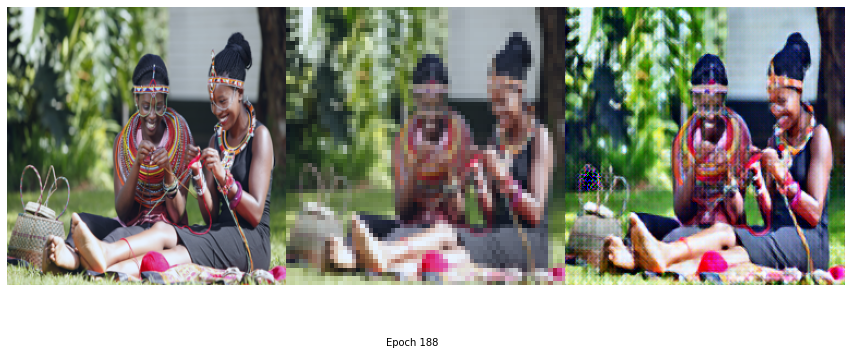

Training Epoch 189 / 191:   0%|          | 0/3303 [00:00<?, ?it/s]

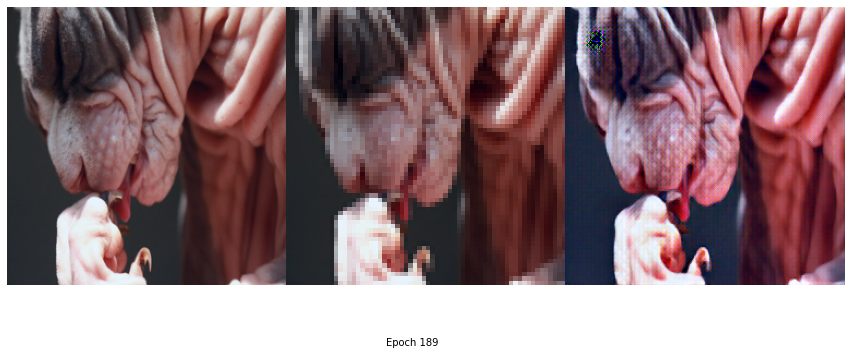

Training Epoch 190 / 191:   0%|          | 0/3303 [00:00<?, ?it/s]

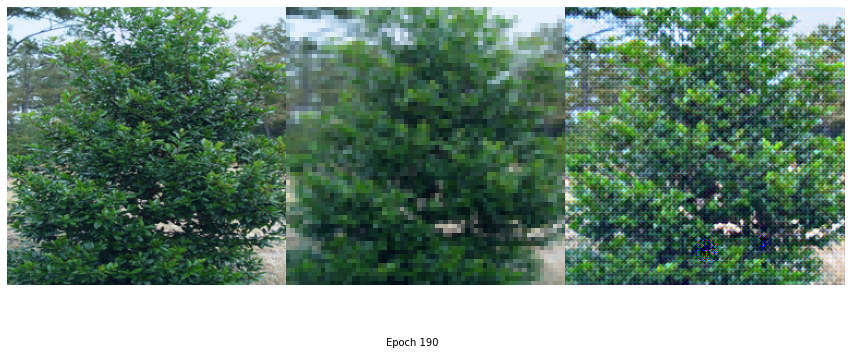

Training Epoch 191 / 191:   0%|          | 0/3303 [00:00<?, ?it/s]

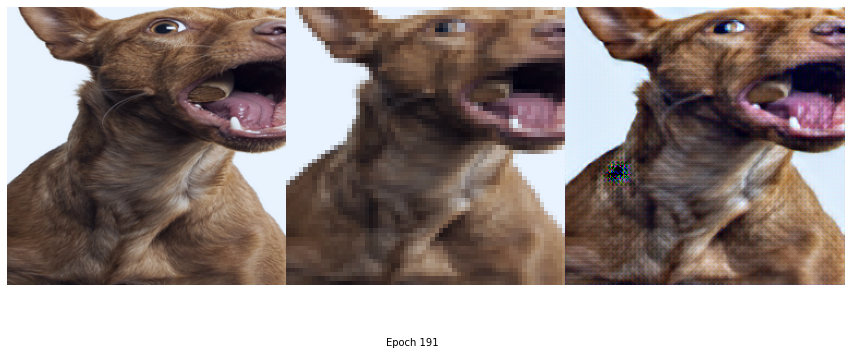

In [ ]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
#test_gen_losses, test_disc_losses = [], []
epochs = 0

epochs, discriminator, optimizer_D, train_disc_losses = load(slpath+"saved_models/discriminator_stronger.pth", discriminator, optimizer_D)
epochs, generator, optimizer_G, train_gen_losses = load(slpath+"saved_models/generator_only_div2k.pth", generator, optimizer_G)

test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]
BA = -1000

for epoch in range(epochs+1, n_epochs+1):
    count = 0
    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} / {n_epochs}', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train()
        #discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        
        ### Train Generator
        optimizer_G.zero_grad()
        
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        #gen.append(gen_hr)
        
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        
        
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        
        loss_content = criterion_content(gen_features, real_features)

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()
        
        writer.add_scalar('loss/Generation', loss_G, epoch)
        
        if(count%9000 == 0):
            plot_train_result(imgs_hr, imgs_lr, gen_hr, epoch = epoch) 
            
        count = count+1  

        '''
        with amp.autocast():
            hr_output = discriminator(imgs_hr)
            sr_output = discriminator(gen_hr.detach().clone())

        # Calculate the score of the discriminator on real samples and fake samples, the score of real samples is close to 1, and the score of fake samples is close to 0
        d_hr_probability = torch.sigmoid_(torch.mean(hr_output.detach()))
        d_sr_probability = torch.sigmoid_(torch.mean(sr_output.detach()))
        '''

        
        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        writer.add_scalar('loss/Discriminator', loss_D, epoch)
        
        '''
        writer.add_scalar("Discriminator(HR)_Probability", d_hr_probability.item(), epoch)
        writer.add_scalar("Discriminator(SR)_Probability", d_sr_probability.item(), epoch)

        hr = imgs_hr.squeeze().reshape(256,256,3).detach().cpu().numpy()
        sr = gen_hr.squeeze().reshape(256,256,3).detach().cpu().numpy()
        
        PSNR = calculate_psnr(hr, sr)
        SSIM = calculate_ssim(hr, sr)
        #print(PSNR, SSIM)
        writer.add_scalar('PSNR', PSNR, epoch)
        writer.add_scalar('SSIM', SSIM, epoch)
        '''

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        #tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1), PSNR = PSNR, SSIM = SSIM, disc_prob = d_sr_probability.item())
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        
    '''
    # Save image grid with upsampled inputs and SRGAN outputs
    imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
    imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
    gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
    imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
    img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
    writer.add_image(f"images/{epoch}.png", img_grid)
    '''
            
    # Save model checkpoints
    torch.save({'epoch': epoch,
                'model_state_dict':generator.state_dict(),
                'optimizer_state_dict': optimizer_G.state_dict(),
                'loss': train_gen_losses},
                slpath+"saved_models/generator_only_div2k.pth")
    
    torch.save({'epoch': epoch,
                'model_state_dict':discriminator.state_dict(),
                'optimizer_state_dict': optimizer_D.state_dict(),
                'loss': train_disc_losses},
                slpath+"saved_models/discriminator_stronger.pth")
    

In [ ]:
torch.save(generator.state_dict(), slpath+"saved_models/generator_div2k.pt")

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/MyDrive/happy_images/runs' #'/content/drive/MyDrive/happy_imagesruns/metrics'

Launching TensorBoard...

In [ ]:
lr_transform = transforms.Compose(
            [
                transforms.Pad(2),
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
'''
gen_transform = transforms.Compose(
            [
                transforms.RandomAdjustSharpness(2, p=0.99),
                transforms.RandomAutocontrast(p=0.99),
                transforms.RandomEqualize(p=0.9)
            ]
        )
'''

# %cd /content/drive/MyDrive/happy_images/DIV2K_valid_HR/


d = {'HR-Probablity': [], 'SR-Probablity': [], 'SSIM': [], 'PSNR': []}
#for img in os.listdir('/content/drive/MyDrive/face_images/a055a66f-46ea-4c57-8de4-f3cc4f27c59c/')[:5]:
for img in ['/content/drive/MyDrive/face_images/a055a66f-46ea-4c57-8de4-f3cc4f27c59c/'+str(i)+'.jpg' for i in range(1, 5)]:
    epoch, generator, optimizer_G, train_gen_losses = load(slpath+"saved_models/generator_only_div2k.pth", generator, optimizer_G)
    #real_image = Image.open('/content/drive/MyDrive/Kaggle/1653992372606.jpg').convert('RGB')
    real_image = Image.open(img).convert('RGB')
    recon_image = hr_transform(real_image)
    real_image = lr_transform(real_image)
    real_image = torch.unsqueeze(real_image, dim=0)
    real_image = Variable(real_image.type(Tensor))

    gen_image = generator(real_image)
    #gen_image = gen_transform(gen_image)

    with amp.autocast():
        hr_output = discriminator(recon_image.unsqueeze(dim=0))
        #lr_output = discriminator(real_image)
        sr_output = discriminator(gen_image.detach().clone())

    # Calculate the score of the discriminator on real samples and fake samples, the score of real samples is close to 1, and the score of fake samples is close to 0
    d_hr_probability = torch.sigmoid_(torch.mean(hr_output.detach()))
    #d_lr_probability = torch.sigmoid_(torch.mean(lr_output.detach()))
    d_sr_probability = torch.sigmoid_(torch.mean(sr_output.detach()))

    hr = recon_image.squeeze().reshape(256,256,3).detach().cpu().numpy()
    sr = gen_image.squeeze().reshape(256,256,3).detach().cpu().numpy()
        
    PSNR = calculate_psnr(hr, sr)
    SSIM = calculate_ssim(hr, sr)

    d['HR-Probablity'] += [d_hr_probability.item()]
    d['SR-Probablity'] += [d_sr_probability.item()]
    d['SSIM'] += [SSIM]
    d['PSNR'] += [PSNR]

    fig, axes = plt.subplots(1, 3, figsize=(12,5))
    labels = ['Low-Resolution Image', 'Super-Resolution Image', 'High-Resolution Image']
    imgs = [to_np(real_image), to_np(gen_image), to_np(recon_image)]
    for i, (ax, img) in enumerate(zip(axes.flatten(), imgs)):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
        ax.set_title(labels[i])
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Probablity: {0}, SSIM: {1}, PSNR: {2}, Epoch: {3}'.format(d_sr_probability.item(), SSIM, PSNR, epoch)
    fig.text(0.5, 0.04, title, ha='center')
    plt.show()
    #plt.close()
df = pd.DataFrame.from_dict(d)
df

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

In [ ]:
os.mkdir('val_outputs')

In [ ]:
#validation
count=0
val_path = '../input/super-image-resolution/Data/LR/'
for img in os.listdir(val_path):
    imgs_lr = Image.open(val_path+img)
    imgs_lr = ToTensor()(imgs_lr).unsqueeze(0).cuda()
    gen_hr = generator(imgs_lr)

    plot_train_result(imgs_lr, imgs_lr, gen_hr)
    save_image(gen_hr, f"val_outputs/{count}.png", normalize=True)
    count=count+1

In [ ]:
!tar -zcvf val_results.tar.gz /kaggle/working/val_outputs